# Capstone Project

## Loading libraries

First step is to make sure all of these python libraries are available for usage

In [35]:
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
from PIL import Image
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import os
import urllib
import random
import cPickle as pickle
%matplotlib inline

Download the required datasets.

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename):
  """Download a file if not present"""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
    print filename, "download completed."
  else:
    print 'Filename:', filename, 'is already downloaded.'
  return filename

# download the datasets if necessary
train_dataset_filename = maybe_download("train_32x32.mat")
test_dataset_filename = maybe_download("test_32x32.mat")

Filename: train_32x32.mat is already downloaded.
Filename: test_32x32.mat is already downloaded.


Load training and testing sets.

In [3]:
traning_size = 73257
testing_size = 26032
extra_size = 531131

raw_train_data = sio.loadmat(train_dataset_filename)
raw_test_data = sio.loadmat(test_dataset_filename)

train_dataset, train_labels =  raw_train_data["X"], raw_train_data["y"]
test_dataset, test_labels = raw_test_data["X"], raw_test_data["y"]

# free up memory from the notebook cache
%xdel raw_train_data
%xdel raw_test_data

print "Train dataset shape:", train_dataset.shape
print "Train labels shape:",train_labels.shape
print "Test dataset shape:",test_dataset.shape
print "Test labels shape:",test_labels.shape

Train dataset shape: (32, 32, 3, 73257)
Train labels shape: (73257, 1)
Test dataset shape: (32, 32, 3, 26032)
Test labels shape: (26032, 1)


## Image processing

Reshape the datasets for better index accessing

In [4]:
image_size = 32  # Pixel width and height.
number_of_channels = 3

def reshape_dataset(data, n_of_images):
    dataset = np.ndarray(shape=(n_of_images, image_size, image_size, number_of_channels), dtype=np.uint8) 
    for index in range(0,n_of_images):
        dataset[index,:,:,:] = data[:,:,:,index]
    return dataset
    
train_dataset = reshape_dataset(train_dataset, traning_size)
test_dataset = reshape_dataset(test_dataset, testing_size)

print "Train dataset shape:", train_dataset.shape
print "Train labels shape:",train_labels.shape
print "Test dataset shape:",test_dataset.shape
print "Test labels shape:",test_labels.shape

Train dataset shape: (73257, 32, 32, 3)
Train labels shape: (73257, 1)
Test dataset shape: (26032, 32, 32, 3)
Test labels shape: (26032, 1)


Display some of the images just to make sure everything is fine.

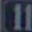

[1]


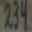

[3]


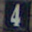

[4]


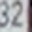

[2]


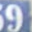

[9]


In [5]:
def display_images_at_random(dataset, labels, size, N):
    random.seed(1)
    # display the first n images
    for i in random.sample(xrange(size), N):
        img = dataset[i,:,:,:]
        display(Image.fromarray(img, 'RGB'))
        print labels[i]
        
display_images_at_random(train_dataset, train_labels, traning_size, 5)

### Labels processing

According to the dataset specs, in the SVHN dataset, there are 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Let's make each of the images with 0s to have a class label of '0' instead of '10'.

In [6]:
for index in range(0,train_labels.size):
    if train_labels[index] == 10:
        train_labels[index] = 0
        
for index in range(0,test_labels.size):
    if test_labels[index] == 10:
        test_labels[index] = 0

# reshape the labels to be 1-D array
train_labels = train_labels.reshape(train_labels.size)
test_labels = test_labels.reshape(test_labels.size)

print "Train labels re-shaped to 1-D:",train_labels.shape
print "Test labels re-shaped to 1-D:",test_labels.shape

Train labels re-shaped to 1-D: (73257,)
Test labels re-shaped to 1-D: (26032,)


Another check: we expect the data to be balanced across classes.

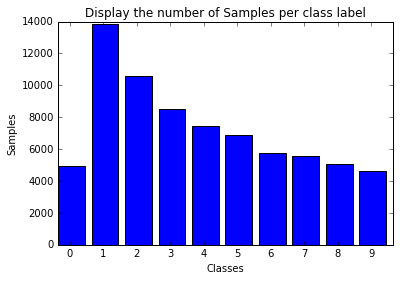

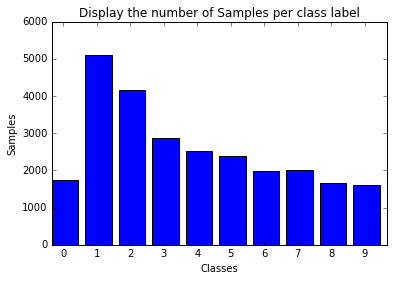

In [7]:
# verify if the data is well balanced across the classes
def display_data_distribution(labels):
    data_distribution = np.bincount(labels)

    index = np.arange(10)
    plt.bar(index, data_distribution)
    plt.title("Display the number of Samples per class label")
    plt.xlabel('Classes')
    plt.ylabel('Samples')

    bar_width = 0.35
    plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))

    plt.show()
    
display_data_distribution(train_labels)
display_data_distribution(test_labels)

As we can see, the distribution of images per class is not well balanced. There are much more images of class 1 than any other. Also, we notice that there are more than twice more images from class '1' than from class '0', '6', '7', '8', and '9'. However, we have to measure how balanced the classes in this dataset are.

In [8]:
def calculate_dataset_distribution_rate(dataset_labels):
    data_distribution = np.bincount(dataset_labels)
    K = len(data_distribution)
    N = len(dataset_labels)
    c = 0
    for ck in data_distribution:
        c += (ck - (N/K))**2

    return (1.0/N)*((1.0/(K-1.0) * c) ** (0.5)) * 100

print calculate_dataset_distribution_rate(train_labels)

4.02986151914


Let's create a new totally balanced dataset using both the training and testing sets. This new dataset will have 80000 example images and our goal is to make each class to have exactly 8000 samples. 

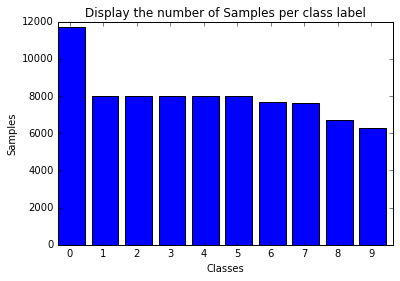

In [9]:
NEW_DATASET_SIZE = 80000
dataset = np.zeros(shape=(NEW_DATASET_SIZE, image_size, image_size, number_of_channels), dtype=np.uint8)
labels = np.zeros(shape=(NEW_DATASET_SIZE, 1), dtype=np.uint8)

distribution = [0,0,0,0,0,0,0,0,0,0]
SAMPLE_LIMIT_PER_CLASS = NEW_DATASET_SIZE / 10
new_data_index = 0

index_train = 0
for label in train_labels:
    if distribution[label] < SAMPLE_LIMIT_PER_CLASS:
        dataset[new_data_index,:,:,:] = train_dataset[index_train]
        labels[new_data_index,:] = label
        distribution[label] += 1
        new_data_index += 1
        index_train += 1
    
index_test = 0
for label in test_labels:
    if distribution[label] < SAMPLE_LIMIT_PER_CLASS:
        dataset[new_data_index,:,:,:] = test_dataset[index_test]
        labels[new_data_index,:] = label
        distribution[label] += 1
        new_data_index += 1
        index_test += 1
        
# free up memory from the notebook cache
%xdel train_dataset
%xdel train_labels
%xdel test_dataset
%xdel test_labels

display_data_distribution(labels.reshape(NEW_DATASET_SIZE))

We can see that even combining both training and testing sets, they both do not have sufficient data for filling each of the classes with 8000 example images. Because of that lets load up the extra dataset in order to fill this gap. Note that the higher class 0 bar does not mean that there actually are nearly 12000 elements there, this behaviour is because we start off the new dataset labels with 0s.  

In [10]:
extra_dataset_filename = maybe_download("extra_32x32.mat")

# load the dataset
raw_extra_data = sio.loadmat(extra_dataset_filename)

# get the data variables
extra_dataset, extra_labels = raw_extra_data["X"], raw_extra_data["y"]

# free up 
%xdel raw_extra_data

print "Extra dataset shape:",extra_dataset.shape
print "Extra labels shape:",extra_labels.shape

Filename: extra_32x32.mat is already downloaded.
Extra dataset shape: (32, 32, 3, 531131)
Extra labels shape: (531131, 1)


Now let's reshape this new dataset and convert the classes as we did to the training and testing sets.

Extra dataset shape: (531131, 32, 32, 3)
Extra labels shape: (531131, 1)
Extra labels re-shaped to 1-D: (531131,)


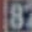

8


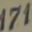

7


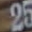

2


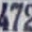

7


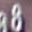

8


In [11]:
extra_dataset = reshape_dataset(extra_dataset, extra_size)

print "Extra dataset shape:",extra_dataset.shape
print "Extra labels shape:",extra_labels.shape

# convert the class label 10 to be 0
for index in range(0,extra_labels.size):
    if extra_labels[index] == 10:
        extra_labels[index] = 0

# reshape the labels to be 1-D array
extra_labels = extra_labels.reshape(extra_labels.size)
print "Extra labels re-shaped to 1-D:",extra_labels.shape

# display some images for checking
display_images_at_random(extra_dataset, extra_labels, extra_size, 5)

Now, fill out the new dataset.

74969


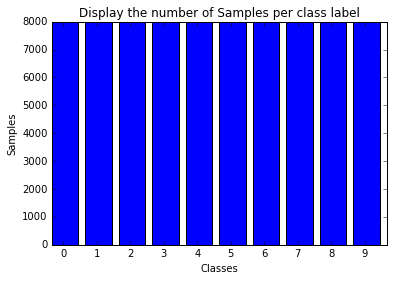

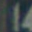

[1]


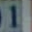

[0]


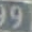

[8]


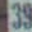

[3]


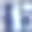

[1]


In [12]:
print new_data_index

index_extra = 0
for label in extra_labels:
    if distribution[label] < SAMPLE_LIMIT_PER_CLASS:
        dataset[new_data_index,:,:,:] = extra_dataset[index_extra]
        labels[new_data_index,:] = label
        distribution[label] += 1
        new_data_index += 1
        index_extra += 1
  
# free up 
%xdel extra_dataset
%xdel extra_labels

# redisplay the data distribution
display_data_distribution(labels.reshape(NEW_DATASET_SIZE))

display_images_at_random(dataset, labels, NEW_DATASET_SIZE, 5)

Now if we avaluate the balance factor of this new dataset, we will see a very small number which indicated that the dataset is well balanced.

In [13]:
print "New dataset shape:", dataset.shape
print "New labels shape:", labels.shape

print calculate_dataset_distribution_rate(labels.reshape(NEW_DATASET_SIZE))

New dataset shape: (80000, 32, 32, 3)
New labels shape: (80000, 1)
0.0


Let's procede by normalizing our images in order to have the mean and variable close to 0.

Mean: 0.261159
Standard deviation: 0.186185


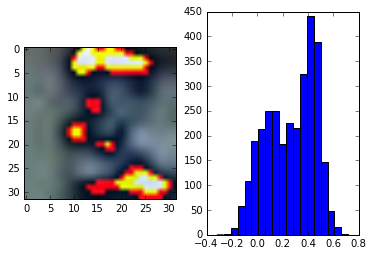

In [14]:
pixel_depth = 128.0  # Number of levels per pixel.

# take one image
image = dataset[100] # get an image

scaled = image.astype(np.float32) # convert to float
scaled = (scaled - pixel_depth) / pixel_depth # normalize

# display the normalized image
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(scaled, cmap=plt.cm.Greys);
ax2.hist(np.reshape(scaled, 3072), bins=20, range=[np.min(scaled) - 0.1, np.max(scaled) + 0.1]);

print 'Mean:', np.mean(scaled)
print 'Standard deviation:', np.std(scaled)

Apply normalization to the entiry dataset.

In [15]:
dataset = dataset.astype(np.float32) # convert to float
dataset = (dataset - pixel_depth) / pixel_depth # normalize

Label: [2]


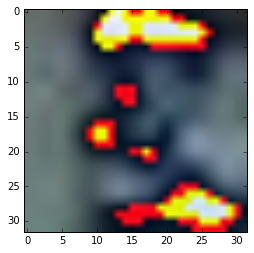

In [17]:
# display the normalized image
_, ax1 = plt.subplots(1, 1)
ax1.imshow(dataset[100], cmap=plt.cm.Greys);
print "Label:", labels[100]

### Creating training, validation and testing dataset

Now we are in perfect conditions to create normalized well balanced training, validating and testing sets. 

In [29]:
TESTING_DATASET_SIZE = 20000
VALIDATING_DATASET_SIZE = 10000

dataset, X_test, labels, y_test = train_test_split(dataset, labels, test_size=TESTING_DATASET_SIZE, 
                                                    random_state=42, stratify=labels)

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(dataset, labels, test_size=VALIDATING_DATASET_SIZE, 
                                                    random_state=42, stratify=labels)

In [31]:
print "Training data shape:", X_train.shape
print "Validating data shape:", X_valid.shape
print "Testing data shape:", X_test.shape

Training data shape: (50000, 32, 32, 3)
Validating data shape: (10000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


Save these dataset for later reuse.

In [36]:
pickle_file = 'dataset.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': X_train,
    'train_labels': y_train,
    'valid_dataset': X_valid,
    'valid_labels': y_valid,
    'test_dataset': X_test,
    'test_labels': y_test,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [37]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 983120452


## Labels processing

Machine Learning and Knowledge Discovery in Databases: European ..., Part 2

https://books.google.com.br/books?id=dHNqCQAAQBAJ&pg=PA278&lpg=PA278&dq=MNIST+dataset+well+balanced&source=bl&ots=L3lX0nNyKn&sig=xg6Sj_0Xk5m3fI8sMdivM0ZWAqA&hl=en&sa=X&ved=0ahUKEwinpfzj_M3NAhVJOZAKHfEKAeAQ6AEIKzAC#v=onepage&q=MNIST%20dataset%20well%20balanced&f=false

Let's remove some images to make the classes more well balanced.

Let's move on to loading the full set of labels. As is typical in classification problems, we'll convert our input labels into a [1-hot](https://en.wikipedia.org/wiki/One-hot) encoding over a length 10 vector corresponding to 10 digits. The vector [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], for example, would correspond to the digit 1.

In [46]:
NUM_LABELS = 10

def convert_to_one_hot(labels):
    return (np.arange(NUM_LABELS) == labels[:, None]).astype(np.float32)

# convert the image labels to onehot notation
train_labels_h = convert_to_one_hot(train_labels)
test_labels_h = convert_to_one_hot(test_labels)

Let's check if out 1-hot encondings match our expectations

In [47]:
print 'Training labels shape', train_labels_h.shape
print 'First label vector', train_labels_h[0]
print 'Second label vector', train_labels_h[1]

Training labels shape (26032, 10)
First label vector [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Second label vector [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
